In [2]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from scipy.spatial.distance import cosine
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_parquet("../dataset/data/train-00000-of-00001.parquet")
df["label"] = df["clarity_label"]
if "question" not in df.columns:
    df["question"] = df["interview_question"]

print(f"Total: {len(df)}")
print(df["label"].value_counts())

Total: 3448
label
Ambivalent         2040
Clear Reply        1052
Clear Non-Reply     356
Name: count, dtype: int64


In [3]:
sbert = SentenceTransformer("all-MiniLM-L6-v2")

features_list = []
for idx, row in df.iterrows():
    if idx % 500 == 0:
        print(f"{idx}/{len(df)}")

    q = str(row["question"])
    a = str(row["interview_answer"])
    q_lower = q.lower()
    a_lower = a.lower()
    q_words = q_lower.split()
    a_words = a_lower.split()

    q_emb = sbert.encode(q)
    a_emb = sbert.encode(a[:1500])

    f = {}
    f["semantic_sim"] = 1 - cosine(q_emb, a_emb)

    first_sent = a.split('.')[0] if '.' in a else a[:150]
    first_emb = sbert.encode(first_sent)
    f["first_sent_sim"] = 1 - cosine(q_emb, first_emb)

    f["a_len_words"] = len(a_words)
    f["q_len_words"] = len(q_words)
    f["a_q_ratio"] = len(a_words) / max(len(q_words), 1)

    direct_yes = {"yes", "yeah", "absolutely", "definitely",
                  "certainly", "correct", "exactly", "right", "sure"}
    direct_no = {"no", "nope", "never", "not"}
    first_word = a_words[0] if a_words else ""
    first_5 = set(a_words[:5]) if len(a_words) >= 5 else set(a_words)

    f["starts_yes"] = int(
        first_word in direct_yes or len(first_5 & direct_yes) > 0)
    f["starts_no"] = int(first_word in direct_no)
    f["starts_direct"] = f["starts_yes"] or f["starts_no"]
    f["starts_well"] = int(first_word == "well")
    f["starts_i"] = int(first_word == "i")

    yes_no_q = ["do ", "does ", "did ", "is ", "are ",
                "was ", "were ", "will ", "would ", "can "]
    f["is_yes_no_q"] = int(any(q_lower.startswith(s) for s in yes_no_q))
    f["yes_no_q_direct_a"] = int(f["is_yes_no_q"] and f["starts_direct"])

    refusal = ["i can't", "i cannot", "i won't", "no comment",
               "i'm not going to", "i don't know", "decline to", "not prepared"]
    f["has_refusal"] = int(any(r in a_lower for r in refusal))

    ignorance = ["i don't know", "i'm not aware",
                 "no idea", "not sure", "i haven't"]
    f["claims_ignorance"] = int(any(i in a_lower for i in ignorance))

    f["has_question"] = int("?" in a)
    f["ends_question"] = int(a.strip().endswith("?"))

    hedges = ["maybe", "perhaps", "possibly",
              "probably", "might", "could", "somewhat"]
    f["hedge_count"] = sum(1 for h in hedges if h in a_lower)

    commitment = ["i will", "i'm going to",
                  "we will", "we're going to", "i promise"]
    f["commitment_count"] = sum(1 for c in commitment if c in a_lower)

    f["sentence_count"] = len([s for s in a.split('.') if s.strip()])
    f["avg_sent_len"] = len(a_words) / max(f["sentence_count"], 1)

    features_list.append(f)

feature_df = pd.DataFrame(features_list)
feature_df["label"] = df["label"].values
print(f"\nFeatures: {len(feature_df.columns) - 1}")

0/3448
500/3448
1000/3448
1500/3448
2000/3448
2500/3448
3000/3448

Features: 20


In [4]:
print("="*70)
print("FEATURE MEANS BY CLASS")
print("="*70)

classes = ["Clear Reply", "Ambivalent", "Clear Non-Reply"]
feature_cols = [c for c in feature_df.columns if c != "label"]

results = []
for col in feature_cols:
    row = {"feature": col}
    for cls in classes:
        row[cls] = feature_df[feature_df["label"] == cls][col].mean()

    # Calculate discrimination score
    cr = row["Clear Reply"]
    amb = row["Ambivalent"]
    cnr = row["Clear Non-Reply"]
    std = feature_df[col].std()

    if std > 0:
        row["CR_vs_Amb"] = abs(cr - amb) / std
        row["CR_vs_CNR"] = abs(cr - cnr) / std
        row["Amb_vs_CNR"] = abs(amb - cnr) / std
        row["total_disc"] = row["CR_vs_Amb"] + \
            row["CR_vs_CNR"] + row["Amb_vs_CNR"]
    else:
        row["CR_vs_Amb"] = row["CR_vs_CNR"] = row["Amb_vs_CNR"] = row["total_disc"] = 0

    results.append(row)

results_df = pd.DataFrame(results)
results_df = results_df.sort_values("total_disc", ascending=False)

print("\nTop discriminative features:")
print(results_df[["feature", "Clear Reply", "Ambivalent",
      "Clear Non-Reply", "total_disc"]].head(15).to_string())

FEATURE MEANS BY CLASS

Top discriminative features:
             feature  Clear Reply  Ambivalent  Clear Non-Reply  total_disc
15     ends_question     0.064639    0.070588         0.266854    1.419858
2        a_len_words   272.041825  331.857843       137.806180    1.287066
0       semantic_sim     0.372296    0.324730         0.256554    1.287015
18    sentence_count    16.634981   19.368627         9.191011    1.238856
12       has_refusal     0.132129    0.148039         0.328652    1.067039
1     first_sent_sim     0.259894    0.221067         0.181267    0.867601
4          a_q_ratio    24.339292   26.808655        13.104257    0.820102
16       hedge_count     0.483840    0.552941         0.241573    0.815100
13  claims_ignorance     0.087452    0.109804         0.199438    0.709430
3        q_len_words    13.454373   15.300980        12.632022    0.604302
14      has_question     0.352662    0.404412         0.500000    0.601800
17  commitment_count     0.490494    0.604902  

In [5]:
print("\n" + "="*70)
print("ANOVA F-TEST (higher = more discriminative)")
print("="*70)

f_scores = []
for col in feature_cols:
    groups = [feature_df[feature_df["label"] == cls]
              [col].values for cls in classes]
    f_stat, p_val = stats.f_oneway(*groups)
    f_scores.append({"feature": col, "F-score": f_stat, "p-value": p_val})

f_df = pd.DataFrame(f_scores).sort_values("F-score", ascending=False)
print(f_df.head(15).to_string())


ANOVA F-TEST (higher = more discriminative)
              feature    F-score       p-value
15      ends_question  81.110342  3.788303e-35
2         a_len_words  69.260853  3.231463e-30
18     sentence_count  62.309777  2.613151e-27
0        semantic_sim  61.469387  5.881421e-27
12        has_refusal  42.350922  6.756153e-19
1      first_sent_sim  30.077580  1.122558e-13
4           a_q_ratio  25.912936  6.760292e-12
16        hedge_count  25.866930  7.073755e-12
3         q_len_words  24.002171  4.445788e-11
13   claims_ignorance  17.039440  4.327406e-08
17   commitment_count  15.780699  1.505682e-07
14       has_question  12.489228  3.940636e-06
9            starts_i   9.423121  8.293615e-05
7       starts_direct   6.829338  1.096277e-03
11  yes_no_q_direct_a   4.590465  1.021030e-02


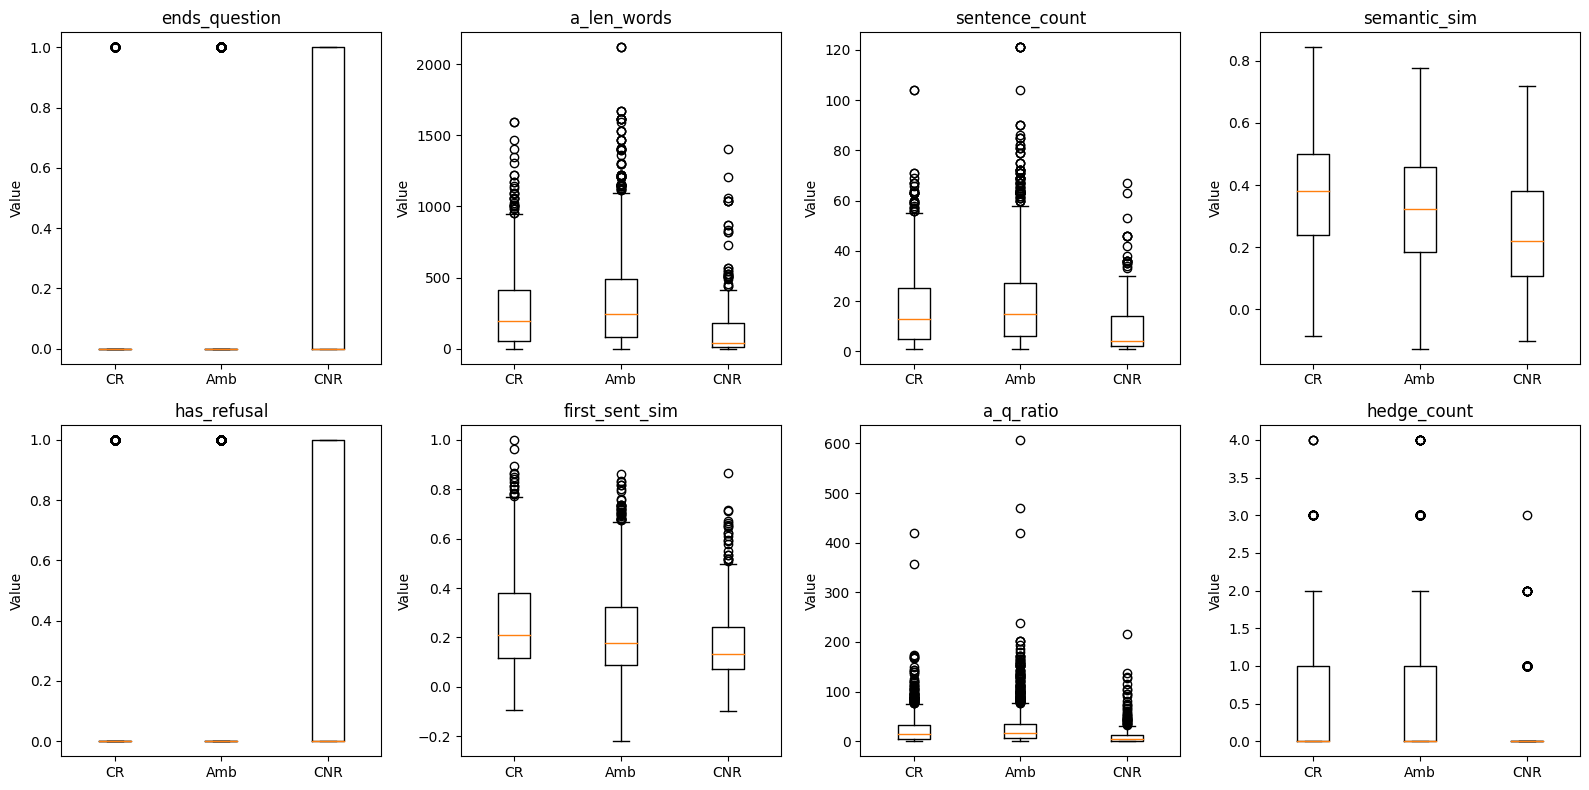

In [6]:
top_features = f_df.head(8)["feature"].tolist()

fig, axes = plt.subplots(2, 4, figsize=(16, 8))
axes = axes.flatten()

for i, feat in enumerate(top_features):
    data = [feature_df[feature_df["label"] == cls]
            [feat].values for cls in classes]
    axes[i].boxplot(data, labels=["CR", "Amb", "CNR"])
    axes[i].set_title(feat)
    axes[i].set_ylabel("Value")

plt.tight_layout()
plt.show()

In [7]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
feature_df["label_encoded"] = le.fit_transform(feature_df["label"])

print("\n" + "="*70)
print("CORRELATION WITH LABEL")
print("="*70)

correlations = []
for col in feature_cols:
    corr = feature_df[col].corr(feature_df["label_encoded"])
    correlations.append(
        {"feature": col, "correlation": corr, "abs_corr": abs(corr)})

corr_df = pd.DataFrame(correlations).sort_values("abs_corr", ascending=False)
print(corr_df.head(15).to_string())


CORRELATION WITH LABEL
              feature  correlation  abs_corr
2         a_len_words    -0.107380  0.107380
0        semantic_sim     0.102604  0.102604
3         q_len_words    -0.100836  0.100836
18     sentence_count    -0.092674  0.092674
1      first_sent_sim     0.085977  0.085977
17   commitment_count    -0.074024  0.074024
16        hedge_count    -0.052701  0.052701
7       starts_direct     0.050265  0.050265
6           starts_no     0.049638  0.049638
4           a_q_ratio    -0.045580  0.045580
10        is_yes_no_q     0.044656  0.044656
11  yes_no_q_direct_a     0.043855  0.043855
14       has_question    -0.039570  0.039570
5          starts_yes     0.030194  0.030194
19       avg_sent_len    -0.021553  0.021553


In [8]:
print("\n" + "="*70)
print("CLASS-SPECIFIC PATTERNS")
print("="*70)

cr = feature_df[feature_df["label"] == "Clear Reply"]
amb = feature_df[feature_df["label"] == "Ambivalent"]
cnr = feature_df[feature_df["label"] == "Clear Non-Reply"]

print(f"\n--- Clear Reply ({len(cr)}) ---")
print(f"  semantic_sim: {cr['semantic_sim'].mean():.3f}")
print(f"  starts_direct: {cr['starts_direct'].mean()*100:.1f}%")
print(f"  a_len_words: {cr['a_len_words'].mean():.0f}")

print(f"\n--- Ambivalent ({len(amb)}) ---")
print(f"  semantic_sim: {amb['semantic_sim'].mean():.3f}")
print(f"  starts_direct: {amb['starts_direct'].mean()*100:.1f}%")
print(f"  a_len_words: {amb['a_len_words'].mean():.0f}")

print(f"\n--- Clear Non-Reply ({len(cnr)}) ---")
print(f"  semantic_sim: {cnr['semantic_sim'].mean():.3f}")
print(f"  starts_direct: {cnr['starts_direct'].mean()*100:.1f}%")
print(f"  has_refusal: {cnr['has_refusal'].mean()*100:.1f}%")
print(f"  claims_ignorance: {cnr['claims_ignorance'].mean()*100:.1f}%")
print(f"  a_len_words: {cnr['a_len_words'].mean():.0f}")


CLASS-SPECIFIC PATTERNS

--- Clear Reply (1052) ---
  semantic_sim: 0.372
  starts_direct: 4.1%
  a_len_words: 272

--- Ambivalent (2040) ---
  semantic_sim: 0.325
  starts_direct: 2.2%
  a_len_words: 332

--- Clear Non-Reply (356) ---
  semantic_sim: 0.257
  starts_direct: 1.1%
  has_refusal: 32.9%
  claims_ignorance: 19.9%
  a_len_words: 138


In [9]:
# Cell: Train with TOP features only
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import classification_report, f1_score, accuracy_score
from sklearn.ensemble import VotingClassifier
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

# Use only top features
TOP_FEATURES = [
    "ends_question", "a_len_words", "semantic_sim", "sentence_count",
    "has_refusal", "first_sent_sim", "a_q_ratio", "hedge_count",
    "claims_ignorance", "has_question"
]

X = feature_df[TOP_FEATURES].values
le = LabelEncoder()
le.fit(["Clear Reply", "Ambivalent", "Clear Non-Reply"])
y = le.transform(feature_df["label"])

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Ensemble
models = [
    ("lgb", lgb.LGBMClassifier(n_estimators=500, max_depth=6,
     learning_rate=0.05, class_weight='balanced', random_state=42, verbose=-1)),
    ("xgb", xgb.XGBClassifier(n_estimators=500, max_depth=6,
     learning_rate=0.05, random_state=42, eval_metric='mlogloss')),
    ("cat", CatBoostClassifier(iterations=500, depth=6, learning_rate=0.05,
     random_state=42, verbose=False, auto_class_weights="Balanced")),
]

vote = VotingClassifier(estimators=models, voting='soft')
vote.fit(X_train_scaled, y_train)
y_pred = vote.predict(X_test_scaled)

print(f"F1: {f1_score(y_test, y_pred, average='macro'):.4f}")
print(f"Acc: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred, target_names=le.classes_))

F1: 0.5225
Acc: 0.5899
                 precision    recall  f1-score   support

     Ambivalent       0.66      0.73      0.69       408
Clear Non-Reply       0.51      0.44      0.47        71
    Clear Reply       0.45      0.37      0.41       211

       accuracy                           0.59       690
      macro avg       0.54      0.51      0.52       690
   weighted avg       0.58      0.59      0.58       690



In [10]:
# Use embeddings + ONLY top linguistic features (reduce noise)
from sklearn.decomposition import PCA

# PCA on embeddings - fewer components to reduce noise
pca_qa = PCA(n_components=50)  # Reduced from 150
X_emb_pca = pca_qa.fit_transform(Combined_emb)

# Only top 8 linguistic features
TOP_LING = ["semantic_sim", "first_sent_sim", "a_len_words", "sentence_count",
            "has_refusal", "ends_question", "claims_ignorance", "hedge_count"]
X_ling_top = ling_df[TOP_LING].values

# Combine
X_final = np.hstack([X_emb_pca, X_ling_top])
print(f"Final feature count: {X_final.shape[1]}")

scaler = StandardScaler()
X_train_f = scaler.fit_transform(X_final[X_train_idx])
X_test_f = scaler.transform(X_final[X_test_idx])

# Train ensemble
vote = VotingClassifier(estimators=models, voting='soft')
vote.fit(X_train_f, y_train)
y_pred = vote.predict(X_test_f)

print(f"\nF1: {f1_score(y_test, y_pred, average='macro'):.4f}")
print(f"Acc: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred, target_names=le.classes_))

NameError: name 'Combined_emb' is not defined

In [11]:
# Complete cell - compute embeddings + top features + train
from sentence_transformers import SentenceTransformer
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import classification_report, f1_score, accuracy_score
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier
import numpy as np

print("Computing embeddings...")
sbert = SentenceTransformer("all-MiniLM-L6-v2")

q_embs = []
a_embs = []
for idx, row in df.iterrows():
    if idx % 500 == 0:
        print(f"  {idx}/{len(df)}")
    q_embs.append(sbert.encode(str(row["question"])))
    a_embs.append(sbert.encode(str(row["interview_answer"])[:1500]))

Q_emb = np.array(q_embs)
A_emb = np.array(a_embs)
Combined_emb = np.concatenate([Q_emb, A_emb], axis=1)

print(f"Embeddings shape: {Combined_emb.shape}")

# PCA - reduce to 50 components
pca = PCA(n_components=50)
X_emb_pca = pca.fit_transform(Combined_emb)

# Top linguistic features from feature_df
TOP_LING = ["semantic_sim", "first_sent_sim", "a_len_words", "sentence_count",
            "has_refusal", "ends_question", "claims_ignorance", "hedge_count"]
X_ling = feature_df[TOP_LING].values

# Combine
X_final = np.hstack([X_emb_pca, X_ling])
print(f"Final features: {X_final.shape[1]}")

# Labels
le = LabelEncoder()
le.fit(["Clear Reply", "Ambivalent", "Clear Non-Reply"])
y = le.transform(feature_df["label"])

# Split
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y, test_size=0.2, random_state=42, stratify=y)

# Scale
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# Models
models = [
    ("lgb", lgb.LGBMClassifier(n_estimators=500, max_depth=8,
     learning_rate=0.05, class_weight='balanced', random_state=42, verbose=-1)),
    ("xgb", xgb.XGBClassifier(n_estimators=500, max_depth=8,
     learning_rate=0.05, random_state=42, eval_metric='mlogloss')),
    ("cat", CatBoostClassifier(iterations=500, depth=8, learning_rate=0.05,
     random_state=42, verbose=False, auto_class_weights="Balanced")),
]

vote = VotingClassifier(estimators=models, voting='soft')
vote.fit(X_train_s, y_train)
y_pred = vote.predict(X_test_s)

print(f"\nF1: {f1_score(y_test, y_pred, average='macro'):.4f}")
print(f"Acc: {accuracy_score(y_test, y_pred):.4f}")
print(classification_report(y_test, y_pred, target_names=le.classes_))

Computing embeddings...
  0/3448
  500/3448
  1000/3448
  1500/3448
  2000/3448
  2500/3448
  3000/3448
Embeddings shape: (3448, 768)
Final features: 58

F1: 0.5234
Acc: 0.6319
                 precision    recall  f1-score   support

     Ambivalent       0.66      0.84      0.74       408
Clear Non-Reply       0.63      0.31      0.42        71
    Clear Reply       0.53      0.35      0.42       211

       accuracy                           0.63       690
      macro avg       0.60      0.50      0.52       690
   weighted avg       0.62      0.63      0.61       690



In [12]:
# Semantic similarity by class
print("="*50)
print("SEMANTIC SIMILARITY BY CLASS")
print("="*50)

for cls in ["Clear Reply", "Ambivalent", "Clear Non-Reply"]:
    subset = feature_df[feature_df["label"] == cls]
    sim = subset["semantic_sim"]
    print(f"\n{cls} ({len(subset)} samples):")
    print(f"  Mean:   {sim.mean():.4f}")
    print(f"  Std:    {sim.std():.4f}")
    print(f"  Min:    {sim.min():.4f}")
    print(f"  Max:    {sim.max():.4f}")
    print(f"  Median: {sim.median():.4f}")

# Also show overlap
print("\n" + "="*50)
print("OVERLAP ANALYSIS")
print("="*50)
cr = feature_df[feature_df["label"] == "Clear Reply"]["semantic_sim"]
amb = feature_df[feature_df["label"] == "Ambivalent"]["semantic_sim"]
cnr = feature_df[feature_df["label"] == "Clear Non-Reply"]["semantic_sim"]

# What % of Ambivalent has higher sim than CR median?
cr_median = cr.median()
print(f"\nClear Reply median sim: {cr_median:.4f}")
print(
    f"Ambivalent samples with sim > CR median: {(amb > cr_median).mean()*100:.1f}%")
print(
    f"Clear Non-Reply samples with sim > CR median: {(cnr > cr_median).mean()*100:.1f}%")

SEMANTIC SIMILARITY BY CLASS

Clear Reply (1052 samples):
  Mean:   0.3723
  Std:    0.1735
  Min:    -0.0849
  Max:    0.8428
  Median: 0.3822

Ambivalent (2040 samples):
  Mean:   0.3247
  Std:    0.1773
  Min:    -0.1263
  Max:    0.7752
  Median: 0.3242

Clear Non-Reply (356 samples):
  Mean:   0.2566
  Std:    0.1836
  Min:    -0.1011
  Max:    0.7180
  Median: 0.2189

OVERLAP ANALYSIS

Clear Reply median sim: 0.3822
Ambivalent samples with sim > CR median: 39.4%
Clear Non-Reply samples with sim > CR median: 24.7%


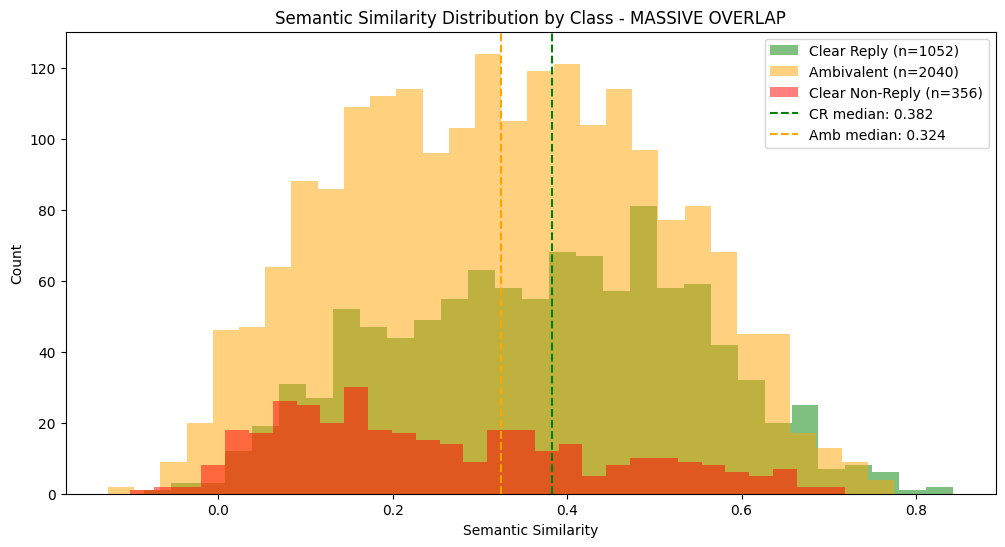

In [13]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 6))

cr_sim = feature_df[feature_df["label"] == "Clear Reply"]["semantic_sim"]
amb_sim = feature_df[feature_df["label"] == "Ambivalent"]["semantic_sim"]
cnr_sim = feature_df[feature_df["label"] == "Clear Non-Reply"]["semantic_sim"]

ax.hist(cr_sim, bins=30, alpha=0.5,
        label=f"Clear Reply (n={len(cr_sim)})", color='green')
ax.hist(amb_sim, bins=30, alpha=0.5,
        label=f"Ambivalent (n={len(amb_sim)})", color='orange')
ax.hist(cnr_sim, bins=30, alpha=0.5,
        label=f"Clear Non-Reply (n={len(cnr_sim)})", color='red')

ax.axvline(cr_sim.median(), color='green', linestyle='--',
           label=f'CR median: {cr_sim.median():.3f}')
ax.axvline(amb_sim.median(), color='orange', linestyle='--',
           label=f'Amb median: {amb_sim.median():.3f}')

ax.set_xlabel("Semantic Similarity")
ax.set_ylabel("Count")
ax.set_title("Semantic Similarity Distribution by Class - MASSIVE OVERLAP")
ax.legend()
plt.show()